In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
from utils import TimeseriesDataset
from model import nts_RNN, nts_MLP

In [22]:
def train_model(data_loader, model, loss_function, optimizer, MLP_flag=False):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        if MLP_flag:
            X = torch.swapaxes(X, 1, 2)
        output = model(X)
        if MLP_flag:
            output = torch.swapaxes(output, 1, 2)
        else:
            output = torch.swapaxes(output, 0, 1)
            output = torch.swapaxes(output, 1, 2)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss/num_batches
    return avg_loss

In [23]:
def run_training(dataset_name, seq_len, fut_len, batch_size, learning_rate, hidden_size, weight_decay, save_model, model_save_name, MLP_flag=False):
    train_dataset = TimeseriesDataset(dataset_name, seq_len, fut_len)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    if MLP_flag:
        model = nts_MLP(hidden_size, input_size=seq_len, fut_len=fut_len)
    else:
        model = nts_RNN(hidden_size, fut_len)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    num_epoch = 1000
    loss_log = np.zeros(num_epoch)
    for epoch_id in tqdm(range(num_epoch)):
        loss_log[epoch_id] = train_model(train_loader, model, loss_function, optimizer, MLP_flag)
        if epoch_id % 100 == 0 or epoch_id == num_epoch - 1:
            print(f"Epoch {epoch_id}, loss: {loss_log[epoch_id]}\n-----------")

    if save_model == True:
        torch.save(model.state_dict(), "trained_models/" + model_save_name)
    return model, loss_log

  0%|          | 2/1000 [00:00<02:02,  8.13it/s]

Epoch 0, loss: 0.19469711913184806
-----------


 10%|█         | 102/1000 [00:10<01:33,  9.57it/s]

Epoch 100, loss: 0.04928418081049081
-----------


 20%|██        | 202/1000 [00:21<01:22,  9.64it/s]

Epoch 200, loss: 0.044413052908666845
-----------


 30%|███       | 302/1000 [00:31<01:12,  9.66it/s]

Epoch 300, loss: 0.04394988768867084
-----------


 40%|████      | 402/1000 [00:41<01:02,  9.59it/s]

Epoch 400, loss: 0.04203406311980971
-----------


 50%|█████     | 502/1000 [00:52<00:52,  9.55it/s]

Epoch 500, loss: 0.04199569246598652
-----------


 60%|██████    | 602/1000 [01:03<00:43,  9.14it/s]

Epoch 600, loss: 0.04168852322458566
-----------


 70%|███████   | 702/1000 [01:13<00:30,  9.68it/s]

Epoch 700, loss: 0.04196312481148557
-----------


 80%|████████  | 802/1000 [01:23<00:20,  9.65it/s]

Epoch 800, loss: 0.041156577662779734
-----------


 90%|█████████ | 902/1000 [01:34<00:10,  9.65it/s]

Epoch 900, loss: 0.040300744718738964
-----------


100%|██████████| 1000/1000 [01:44<00:00,  9.58it/s]


Epoch 999, loss: 0.04137177116513907
-----------


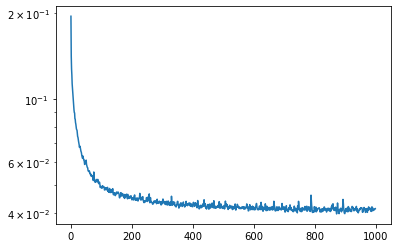

In [63]:
model, loss_log = run_training('TrainSet.mat', 40, 10, 50, 5e-3, [32, 28, 24], 0, True, "MLP3_four_S40_B50_LR2e3_NR.pt", MLP_flag=True)
plt.figure()
plt.plot(range(1000), loss_log)
plt.yscale('log')

(2400.0, 2500.0)

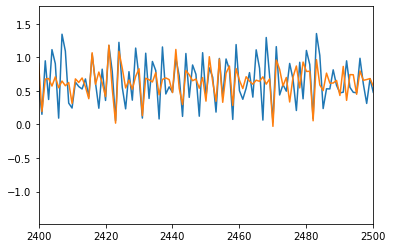

In [58]:
model.eval()
fut_len = 10
batch_size = 1
train_dataset = TimeseriesDataset('TrainSet.mat', seq_len=10, fut_len=fut_len)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
loader = train_loader
loss = np.zeros(len(loader))
gt = np.zeros(len(loader))
pred = np.zeros(len(loader))
loss_function = nn.MSELoss()
for i, (X, y) in enumerate(loader):
    if i%fut_len == 0 and i+fut_len <= len(loader):
        X = torch.swapaxes(X, 1, 2)
        output = model(X)
        output = torch.swapaxes(output, 1, 2)
        # print(output.shape)
        pred[i: i+fut_len] = output.detach().flatten()
        gt[i: i+fut_len] = y.flatten()
        loss[i] = loss_function(output, y)

plt.figure()
plt.plot(range(len(loader)), gt)
plt.plot(range(len(loader)), pred)
plt.xlim([2400, 2500])

  0%|          | 1/1000 [00:00<07:01,  2.37it/s]

Epoch 0, loss: 0.23438057385303163
-----------


 10%|█         | 101/1000 [00:39<05:57,  2.52it/s]

Epoch 100, loss: 0.06550562127933397
-----------


 20%|██        | 201/1000 [01:17<05:12,  2.55it/s]

Epoch 200, loss: 0.1054607779606358
-----------


 30%|███       | 301/1000 [02:03<04:31,  2.57it/s]

Epoch 300, loss: 0.1164467436681082
-----------


 40%|████      | 401/1000 [02:42<03:53,  2.57it/s]

Epoch 400, loss: 0.1018005027793921
-----------


 50%|█████     | 501/1000 [03:21<03:11,  2.60it/s]

Epoch 500, loss: 0.09606744168878911
-----------


 60%|██████    | 601/1000 [04:00<02:35,  2.56it/s]

Epoch 600, loss: 0.17844759869379
-----------


 70%|███████   | 701/1000 [04:39<01:59,  2.50it/s]

Epoch 700, loss: 0.11651490530469916
-----------


 80%|████████  | 801/1000 [05:18<01:16,  2.61it/s]

Epoch 800, loss: 0.18373597863611285
-----------


 90%|█████████ | 901/1000 [05:56<00:37,  2.63it/s]

Epoch 900, loss: 0.17871079864082756
-----------


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]

Epoch 999, loss: 0.23434638125555857
-----------


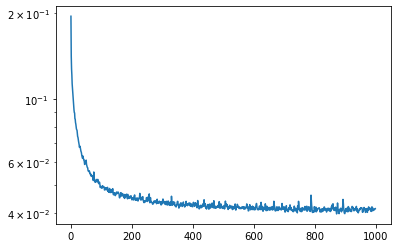

In [64]:
model_rnn, loss_log_rnn = run_training('TrainSet.mat', 40, 10, 50, 5e-3, [32, 28, 24], 0, True, "L3_four_S40_B50_LR5e3_NR.pt", MLP_flag=False)
plt.figure()
plt.plot(range(1000), loss_log)
plt.yscale('log')

/Users/sunbochentang/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([1, 1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(2400.0, 2500.0)

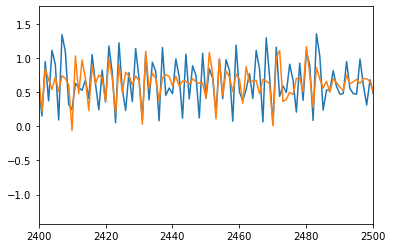

In [60]:
model_rnn.eval()
fut_len = 10
batch_size = 1
train_dataset = TimeseriesDataset('TrainSet.mat', seq_len=10, fut_len=fut_len)
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
loader = train_loader
loss = np.zeros(len(loader))
gt = np.zeros(len(loader))
pred = np.zeros(len(loader))
loss_function = nn.MSELoss()
for i, (X, y) in enumerate(loader):
    if i%fut_len == 0 and i+fut_len <= len(loader):
        output = model_rnn(X)
        # print(output.shape)
        pred[i: i+fut_len] = output.detach().flatten()
        gt[i: i+fut_len] = y.flatten()
        loss[i] = loss_function(output, y)

plt.figure()
plt.plot(range(len(loader)), gt)
plt.plot(range(len(loader)), pred)
plt.xlim([2400, 2500])

  0%|          | 2/1000 [00:00<02:58,  5.59it/s]

Epoch 0, loss: 0.1670828694989393
-----------


 10%|█         | 101/1000 [00:18<03:32,  4.24it/s]

Epoch 100, loss: 0.041439431422686836
-----------


 20%|██        | 202/1000 [00:35<02:08,  6.20it/s]

Epoch 200, loss: 0.03456796971814973
-----------


 30%|███       | 302/1000 [00:52<01:50,  6.30it/s]

Epoch 300, loss: 0.03242908629005427
-----------


 40%|████      | 402/1000 [01:09<01:34,  6.30it/s]

Epoch 400, loss: 0.03205955749029642
-----------


 50%|█████     | 502/1000 [01:25<01:19,  6.24it/s]

Epoch 500, loss: 0.03209254448557948
-----------


 60%|██████    | 602/1000 [01:42<01:06,  6.02it/s]

Epoch 600, loss: 0.030740722128609708
-----------


 70%|███████   | 702/1000 [01:59<00:48,  6.12it/s]

Epoch 700, loss: 0.029746084095357537
-----------


 80%|████████  | 802/1000 [02:16<00:30,  6.42it/s]

Epoch 800, loss: 0.028949849368942963
-----------


 90%|█████████ | 902/1000 [02:33<00:17,  5.54it/s]

Epoch 900, loss: 0.029652722456216158
-----------


100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


Epoch 999, loss: 0.029345469324143378
-----------


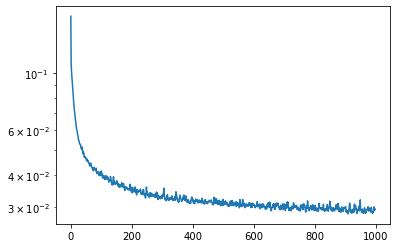

In [65]:
model, loss_log = run_training('TrainSet.mat', 80, 10, 50, 5e-3, [32, 28, 24], 0, True, "MLP3_four_S80_B50_LR2e3_NR.pt", MLP_flag=True)
plt.figure()
plt.plot(range(1000), loss_log)
plt.yscale('log')

  0%|          | 2/1000 [00:00<03:01,  5.49it/s]

Epoch 0, loss: 0.15440729506068177
-----------


 10%|█         | 102/1000 [00:16<02:27,  6.07it/s]

Epoch 100, loss: 0.03473467832165105
-----------


 20%|██        | 202/1000 [00:35<02:14,  5.93it/s]

Epoch 200, loss: 0.030223259159906226
-----------


 30%|███       | 301/1000 [00:52<02:21,  4.93it/s]

Epoch 300, loss: 0.02955895565081756
-----------


 40%|████      | 401/1000 [01:10<02:28,  4.04it/s]

Epoch 400, loss: 0.028804572595917916
-----------


 50%|█████     | 502/1000 [01:28<01:21,  6.11it/s]

Epoch 500, loss: 0.027833429308464892
-----------


 60%|██████    | 602/1000 [01:45<01:05,  6.11it/s]

Epoch 600, loss: 0.02669730289214915
-----------


 70%|███████   | 702/1000 [02:01<00:48,  6.12it/s]

Epoch 700, loss: 0.026582005003897045
-----------


 80%|████████  | 802/1000 [02:17<00:31,  6.19it/s]

Epoch 800, loss: 0.02677876865593614
-----------


 90%|█████████ | 902/1000 [02:34<00:16,  6.06it/s]

Epoch 900, loss: 0.02634360948270494
-----------


100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]

Epoch 999, loss: 0.02564051189551969
-----------


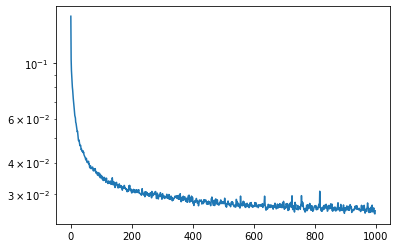

In [66]:
model, loss_log = run_training('TrainSet.mat', 100, 10, 50, 5e-3, [32, 28, 24], 0, True, "MLP3_four_S100_B50_LR2e3_NR.pt", MLP_flag=True)
plt.figure()
plt.plot(range(1000), loss_log)
plt.yscale('log')

  0%|          | 1/1000 [00:00<11:14,  1.48it/s]

Epoch 0, loss: 0.2525484892693195
-----------


 10%|█         | 101/1000 [01:19<10:16,  1.46it/s]

Epoch 100, loss: 0.10678345357978737
-----------


 20%|██        | 201/1000 [02:25<07:26,  1.79it/s]

Epoch 200, loss: 0.2124396411927192
-----------


 30%|███       | 301/1000 [03:25<06:38,  1.75it/s]

Epoch 300, loss: 0.11241156964020414
-----------


 40%|████      | 401/1000 [04:22<05:56,  1.68it/s]

Epoch 400, loss: 0.15022676102407687
-----------


 50%|█████     | 501/1000 [10:40<04:44,  1.75it/s]   

Epoch 500, loss: 0.1208495441210139
-----------


 60%|██████    | 601/1000 [11:43<04:45,  1.40it/s]

Epoch 600, loss: 0.22880620042701344
-----------


 70%|███████   | 701/1000 [12:45<02:46,  1.80it/s]

Epoch 700, loss: 0.22401897052487174
-----------


 80%|████████  | 801/1000 [13:49<02:12,  1.50it/s]

Epoch 800, loss: 0.2589630091583336
-----------


 90%|█████████ | 901/1000 [14:52<01:05,  1.51it/s]

Epoch 900, loss: 0.2539496939260881
-----------


100%|██████████| 1000/1000 [15:50<00:00,  1.05it/s]

Epoch 999, loss: 0.23641348572877738
-----------


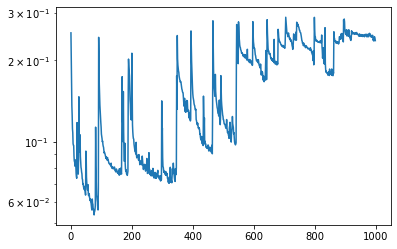

In [67]:
model, loss_log = run_training('TrainSet.mat', 80, 10, 50, 5e-3, [32, 28, 24], 0, True, "L3_four_S80_B50_LR2e3_NR.pt", MLP_flag=False)
plt.figure()
plt.plot(range(1000), loss_log)
plt.yscale('log')

  0%|          | 1/1000 [00:00<12:49,  1.30it/s]

Epoch 0, loss: 0.25603198333755955
-----------


 10%|█         | 101/1000 [01:08<10:12,  1.47it/s]

Epoch 100, loss: 0.18935275781940628
-----------


 20%|██        | 201/1000 [02:18<08:58,  1.48it/s]

Epoch 200, loss: 0.07977955178408833
-----------


 30%|███       | 301/1000 [03:29<07:38,  1.52it/s]

Epoch 300, loss: 0.0646153534916076
-----------


 40%|████      | 401/1000 [04:39<07:09,  1.39it/s]

Epoch 400, loss: 0.07521057489154102
-----------


 50%|█████     | 501/1000 [05:49<06:00,  1.38it/s]

Epoch 500, loss: 0.09673363637629447
-----------


 60%|██████    | 601/1000 [06:59<04:33,  1.46it/s]

Epoch 600, loss: 0.18103477031320006
-----------


 70%|███████   | 701/1000 [08:08<03:18,  1.51it/s]

Epoch 700, loss: 0.10279057117608878
-----------


 80%|████████  | 801/1000 [09:19<02:11,  1.52it/s]

Epoch 800, loss: 0.10630644464885795
-----------


 90%|█████████ | 901/1000 [10:25<01:05,  1.52it/s]

Epoch 900, loss: 0.24256800147858296
-----------


100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]

Epoch 999, loss: 0.20051192189310932
-----------


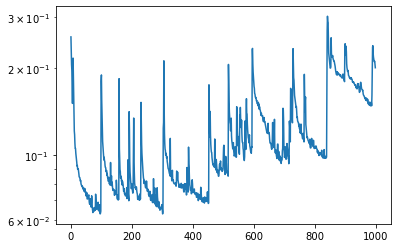

In [68]:
model, loss_log = run_training('TrainSet.mat', 100, 10, 50, 5e-3, [32, 28, 24], 0, True, "L3_four_S100_B50_LR2e3_NR.pt", MLP_flag=False)
plt.figure()
plt.plot(range(1000), loss_log)
plt.yscale('log')